In [83]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist, adjust_gamma, adjust_log
import cv2
from sklearn.preprocessing import normalize

from PIL import Image, ImageEnhance
FONT_SIZE = 16


In [84]:
# img_filmed = imread('abgefilmt.jpg')
# img_clean = imread('orig.jpg')
img_filmed = imread(
    'D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\water\\filmed_small\\filmed_small_00.png')
img_clean = imread('D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\water\\clean_aligned_small\\clean_aligned_small_01.jpg')

RGB_WEIGHTS = [0.299, 0.587, 0.114]



Text(0.5, 1.0, 'img_clean')

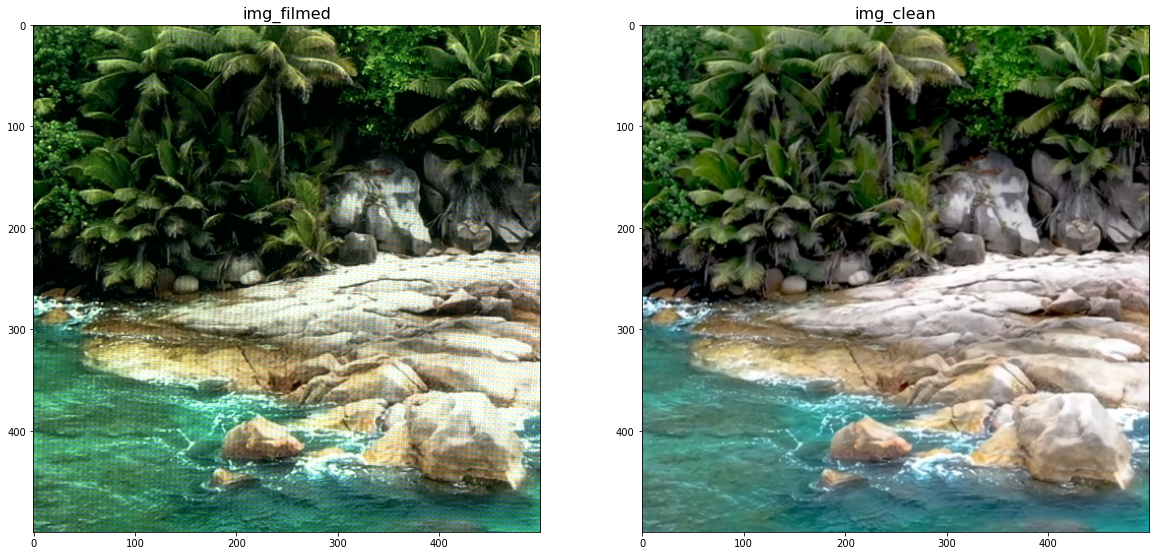

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img_filmed)
ax[0].set_title("img_filmed", fontsize=FONT_SIZE)
ax[1].imshow(img_clean)
ax[1].set_title("img_clean", fontsize=FONT_SIZE)


In [86]:
IMG_HEIGHT =  img_filmed.shape[0]
IMG_WIDTH =  img_filmed.shape[1]


In [87]:
def f2pd(fourier_array):
    # transoforms an fourier image into pixel domain in order
    # to display it
    return (np.log(abs(fourier_array)))


## Split Images into single grayscale images

In [88]:
img_filmed_r = img_filmed[:,:,0]
img_filmed_g = img_filmed[:,:,1]
img_filmed_b = img_filmed[:,:,2]

img_clean_r = img_clean[:,:,0]
img_clean_g = img_clean[:,:,1]
img_clean_b = img_clean[:,:,2]

# for i in range(10):
#     print(f"i: {i}, img_filmed: {img_filmed[i][i]}, img_filmed_r: {img_filmed_b[i][i]}")






## Create Fourier Images


In [89]:
img_filmed_fourier_r = np.fft.fftshift(np.fft.fft2(img_filmed_r))
img_filmed_fourier_g = np.fft.fftshift(np.fft.fft2(img_filmed_g))
img_filmed_fourier_b = np.fft.fftshift(np.fft.fft2(img_filmed_b))

img_clean_fourier_r = np.fft.fftshift(np.fft.fft2(img_clean_r))
img_clean_fourier_g = np.fft.fftshift(np.fft.fft2(img_clean_g))
img_clean_fourier_b = np.fft.fftshift(np.fft.fft2(img_clean_b))



### Automatic mask generation

In [90]:
# combine three images to one grayscale image
img_filmed_fourier_combined = np.zeros((IMG_HEIGHT, IMG_WIDTH))
img_clean_fourier_combined = np.zeros((IMG_HEIGHT, IMG_WIDTH))

img_filmed_fourier_combined = f2pd(img_filmed_fourier_r) * RGB_WEIGHTS[0] + f2pd(img_filmed_fourier_g) * RGB_WEIGHTS[1] + f2pd(img_filmed_fourier_b) * RGB_WEIGHTS[2]
img_clean_fourier_combined = f2pd(img_clean_fourier_r) * RGB_WEIGHTS[0] + f2pd(
    img_clean_fourier_g) * RGB_WEIGHTS[1] + f2pd(img_clean_fourier_b) * RGB_WEIGHTS[2]


In [91]:
def normalize_0_1(img):
    max = np.max(img)
    min = np.min(img)
    img = (img - min) / (max - min)
    return(img)

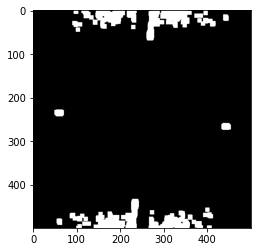

In [92]:
DILATE_KERNEL_SIZE = (10, 10)

# A - B (Filmed - Clean)
fourier_mask = img_filmed_fourier_combined - img_clean_fourier_combined

# normalize image
fourier_mask = normalize_0_1(fourier_mask)

# Blur Image
fourier_mask = cv2.blur(fourier_mask, (6, 6))

# Enlarge Contrast
fourier_mask = adjust_gamma(fourier_mask, 15)

# Threshold Image
fourier_mask = np.where(fourier_mask > 0.0002, 1, 0)

# Dilate Image
kernel = np.ones(DILATE_KERNEL_SIZE, np.float)
fourier_mask = cv2.dilate(fourier_mask.astype("uint8"), kernel)

plt.imshow(fourier_mask, cmap="gray")
plt.show()


## Load fourier mask
- Just if it is not created automatically above

In [93]:
# Load fourier mask
# fourier_mask = imread("fourier_mask_2.png")
# fourier_mask = rgb2gray(fourier_mask)


## Plot combined fourier images and fourier mask

Text(0.5, 1.0, 'fourier mask (simpel grayscale Image) created in Natron')

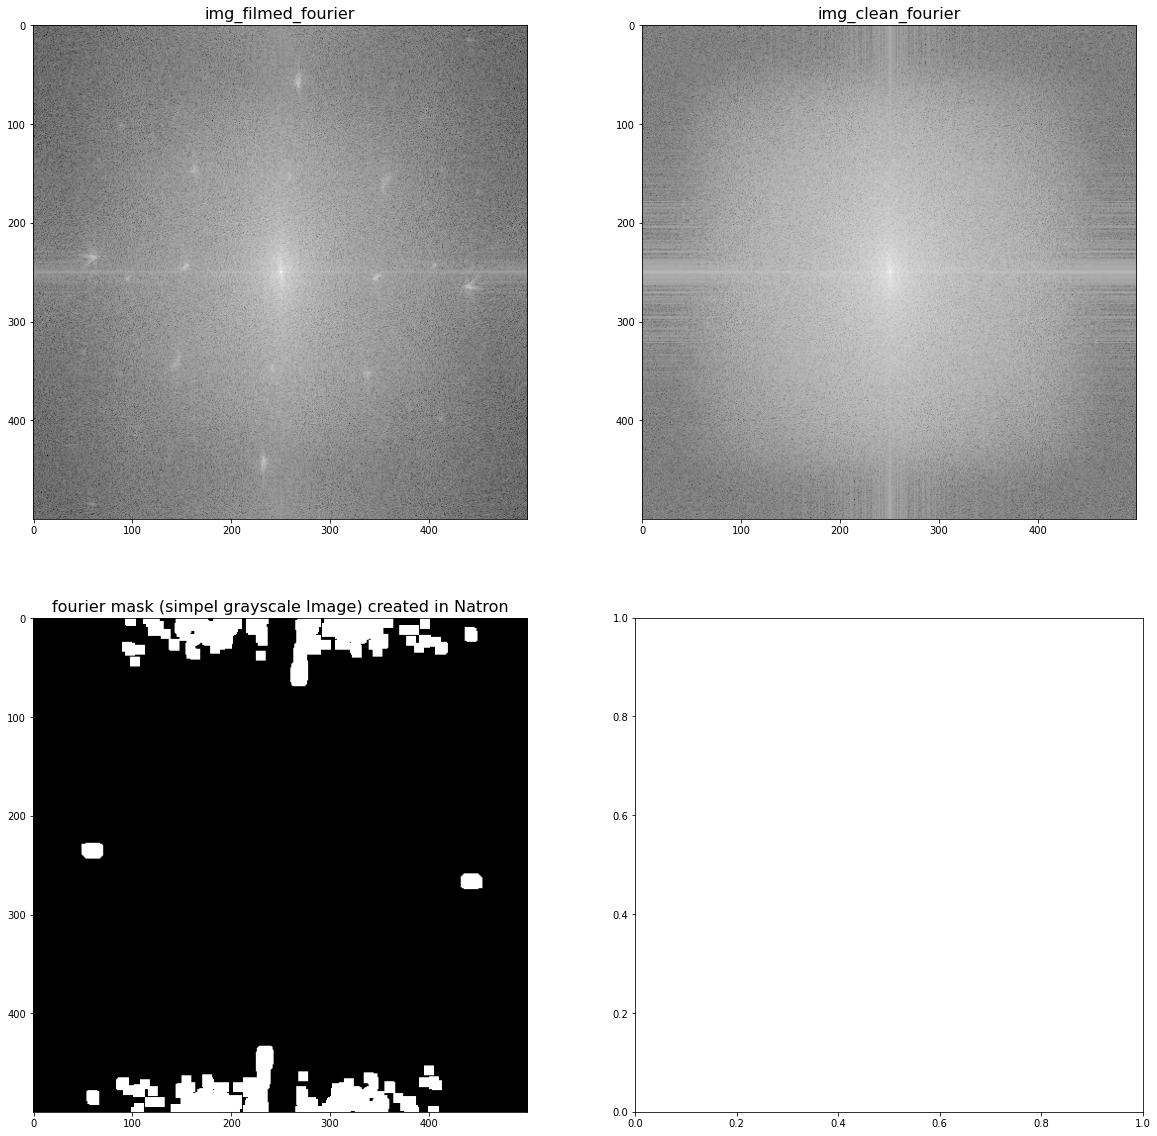

In [94]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))
ax[0][0].imshow(np.log(abs(img_filmed_fourier_combined)), cmap="gray")
ax[0][0].set_title("img_filmed_fourier", fontsize=FONT_SIZE)
ax[0][1].imshow(np.log(abs(img_clean_fourier_combined)), cmap="gray")
ax[0][1].set_title("img_clean_fourier", fontsize=FONT_SIZE)

ax[1][0].imshow(fourier_mask, cmap="gray")
ax[1][0].set_title("fourier mask (simpel grayscale Image) created in Natron", fontsize=FONT_SIZE)


# Loop through images an replace appropriate sections

In [95]:
# plt.imshow(f2pd(img_filmed_fourier_r))
# plt.show()
# plt.imshow(f2pd(img_filmed_fourier_g))
# plt.show()
# plt.imshow(f2pd(img_filmed_fourier_b))
# plt.show()


Text(0.5, 1.0, 'img_filmed_fourier_processed_b')

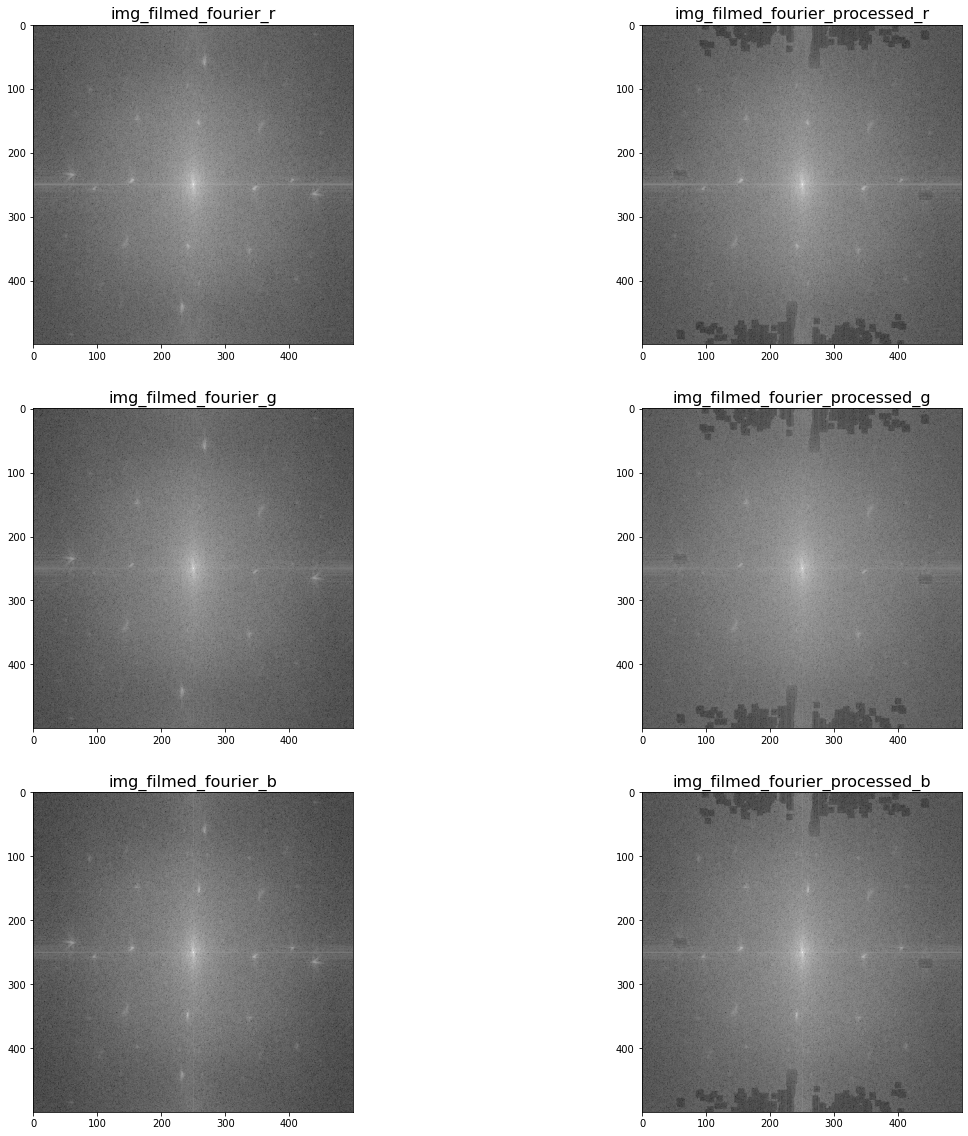

In [96]:

img_filmed_fourier_processed_r = img_filmed_fourier_r.copy()
img_filmed_fourier_processed_g = img_filmed_fourier_g.copy()
img_filmed_fourier_processed_b = img_filmed_fourier_b.copy()

for y in range(IMG_HEIGHT):
    for x in range(IMG_WIDTH):
        if fourier_mask[y][x]==1:
            img_filmed_fourier_processed_r[y][x] = img_clean_fourier_r[y][x]
            img_filmed_fourier_processed_g[y][x] = img_clean_fourier_g[y][x]
            img_filmed_fourier_processed_b[y][x] = img_clean_fourier_b[y][x]


fig, ax = plt.subplots(3, 2, figsize=(20, 20))

ax[0][0].imshow(f2pd(img_filmed_fourier_r), cmap="gray")
ax[0][0].set_title("img_filmed_fourier_r", fontsize=FONT_SIZE)
ax[0][1].imshow(f2pd(img_filmed_fourier_processed_r), cmap="gray")
ax[0][1].set_title("img_filmed_fourier_processed_r", fontsize=FONT_SIZE)


ax[1][0].imshow(f2pd(img_filmed_fourier_g), cmap="gray")
ax[1][0].set_title("img_filmed_fourier_g", fontsize=FONT_SIZE)
ax[1][1].imshow(f2pd(img_filmed_fourier_processed_g), cmap="gray")
ax[1][1].set_title("img_filmed_fourier_processed_g", fontsize=FONT_SIZE)

ax[2][0].imshow(f2pd(img_filmed_fourier_b), cmap="gray")
ax[2][0].set_title("img_filmed_fourier_b", fontsize=FONT_SIZE)
ax[2][1].imshow(f2pd(img_filmed_fourier_processed_b), cmap="gray")
ax[2][1].set_title("img_filmed_fourier_processed_b", fontsize=FONT_SIZE)


# Inverse Fourier Transformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'img_clean')

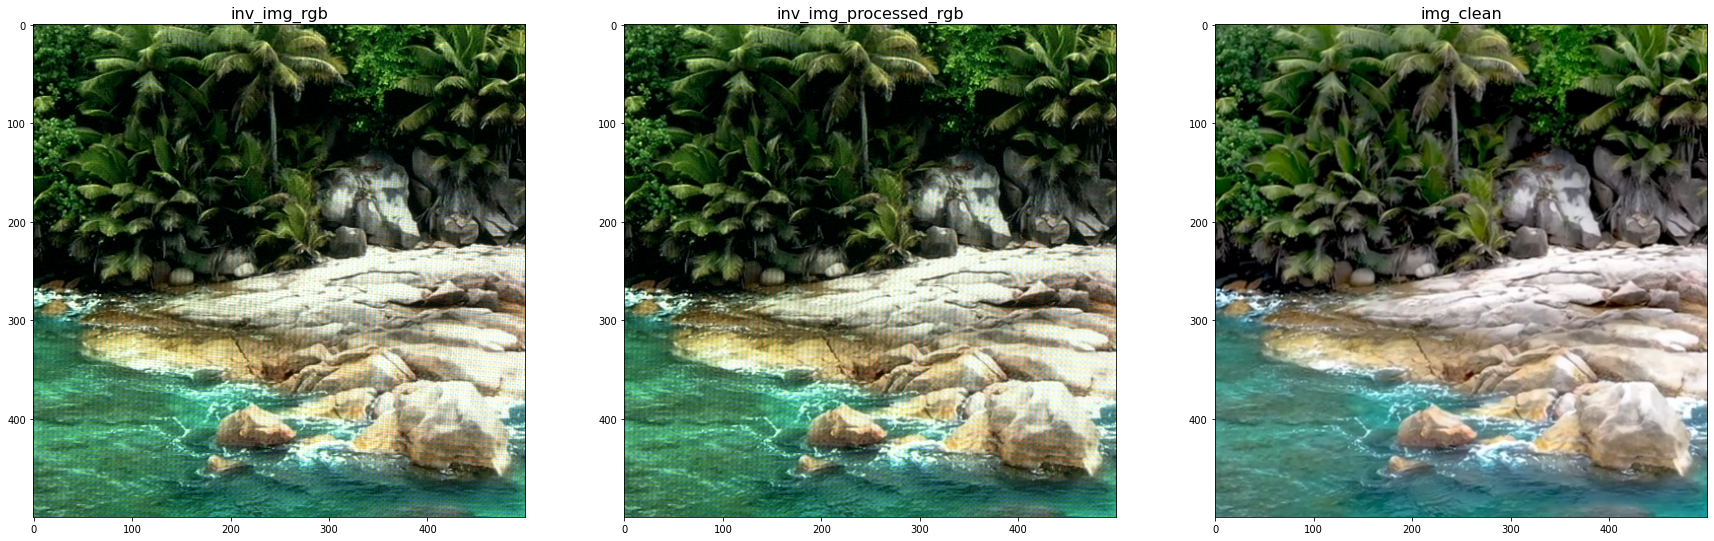

In [97]:
# Inverse-Transform all of the sinle-channel-images
inv_img_r = abs(np.fft.ifft2(img_filmed_fourier_r))
inv_img_g = abs(np.fft.ifft2(img_filmed_fourier_g))
inv_img_b = abs(np.fft.ifft2(img_filmed_fourier_b))

inv_img_processed_r = abs(np.fft.ifft2(img_filmed_fourier_processed_r))
inv_img_processed_g = abs(np.fft.ifft2(img_filmed_fourier_processed_g))
inv_img_processed_b = abs(np.fft.ifft2(img_filmed_fourier_processed_b))

# Concatenate them to one image
inv_img_rgb = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3))
inv_img_rgb[:, :, 0] = inv_img_r[:, :] 
inv_img_rgb[:, :, 1] = inv_img_g[:, :] 
inv_img_rgb[:, :, 2] = inv_img_b[:, :] 
inv_img_rgb = inv_img_rgb.astype(int)

inv_img_processed_rgb = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3))
inv_img_processed_rgb[:, :, 0] = inv_img_processed_r[:, :]
inv_img_processed_rgb[:, :, 1] = inv_img_processed_g[:, :]
inv_img_processed_rgb[:, :, 2] = inv_img_processed_b[:, :]
inv_img_processed_rgb = inv_img_processed_rgb.astype(int)

# plt.imshow(f2pd(inv_img_processed_b), cmap="gray")
# plt.show()

fig, ax = plt.subplots(1, 3, figsize=(30, 30))
ax[0].imshow(inv_img_rgb)
ax[0].set_title('inv_img_rgb', fontsize=FONT_SIZE)
ax[1].imshow(inv_img_processed_rgb)
ax[1].set_title('inv_img_processed_rgb', fontsize=FONT_SIZE)
ax[2].imshow(img_clean)
ax[2].set_title('img_clean', fontsize=FONT_SIZE)


